In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import make_scorer, recall_score, roc_curve, auc
from imblearn.pipeline import Pipeline
# Estimator
from sklearn.linear_model import LogisticRegression

# for SMOTE
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV

# CODE PERSO
import mbr_kernel as mkn
from outils_classification_810 import compute_F2, compute_F2_custom, matrice_de_confusion_binaire
import outils_grid_search_810 as gs810
import outils_mlflow_810 as ml810


NOM_MODELE_BASE='LogisticRegression'

TEST_SIZE = 0.2
RANDOM_STATE = 42
GIT_FOLDER = './'
INPUT_FOLDER = GIT_FOLDER + 'input_data/'
TMP_FOLDER = GIT_FOLDER+'tmp/'

In [2]:
# ---------------------------------------------------------------- MAKE SCRORER
F2_score = make_scorer(compute_F2, greater_is_better=True)
F2custom_score = make_scorer(compute_F2_custom, greater_is_better=True)

In [3]:
def transform_X(X):
    """Applique les transformation qui precede l'estimator dans le Pipeline. Permet d'obtenir une version des donnees telle que l'estimator traitera"""
    imputer = SimpleImputer(missing_values=np.nan, strategy='median')
    scaler = StandardScaler()
    X_imp = imputer.fit_transform(X)
    X_sc = scaler.fit_transform(X_imp)
    new_X=pd.DataFrame(X_sc, columns=X.columns.tolist())
    return  new_X


def test_model(data, estimator, confusion=False, over_sampling=0.1, under_sampling=0.5, do_under=True) :
    """Permet de tester un model, sans enregistrer les resultats dans MLFlow"""
    print("PREPARING MODEL")
    X = data.drop(columns = ['SK_ID_CURR', 'TARGET'])
    y = data['TARGET']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y)
    print(f"X_train : {X_train.shape} // X_test : {X_test.shape}")
    print(f"y_train : {y_train.shape} // y_test : {y_test.shape}")

    imputer = SimpleImputer(missing_values=np.nan, strategy='median')
    scaler = StandardScaler()
    over = SMOTE(sampling_strategy=over_sampling, random_state=RANDOM_STATE)
    if do_under :
        under = RandomUnderSampler(sampling_strategy=under_sampling, random_state=RANDOM_STATE)
    estimator = estimator

    if do_under :
        be = Pipeline([
            ("imputer", imputer),
            ("scaler", scaler),
            ("over", over),
            ("under", under),
            ("estimator", estimator)
        ])
    else :
        be = Pipeline([
            ("imputer", imputer),
            ("scaler", scaler),
            ("over", over),
            ("estimator", estimator)
        ])

    be.fit(X_train, y_train)

    print("TESTING MODEL")
    y_pred = be.predict(X_test)
    y_train_pred = be.predict(X_train)

    fpr, tpr, thresholds = roc_curve(y_train, y_train_pred)
    train_auc_score = auc(fpr, tpr)
    train_F2_score = compute_F2(y_true=y_train, y_pred=y_train_pred)
    train_F2c_score = compute_F2_custom(y_true=y_train, y_pred=y_train_pred)
    train_rappel = recall_score(y_true=y_train, y_pred=y_train_pred)
    print("TRAIN F2 score", train_F2_score)
    print("TRAIN F2Custom score", train_F2c_score)
    print("TRAIN AUC", train_auc_score)
    print("TRAIN Recall", train_rappel)

    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    test_auc_score = auc(fpr, tpr)
    test_F2_score = compute_F2(y_true=y_test, y_pred=y_pred)
    test_F2c_score = compute_F2_custom(y_true=y_test, y_pred=y_pred)
    test_rappel = recall_score(y_true=y_test, y_pred=y_pred)
    print("TEST F2 score", test_F2_score)
    print("TEST F2Custom score", test_F2c_score)
    print("TEST AUC", test_auc_score)
    print("TEST Recall", test_rappel)

    if confusion :
        matrice_de_confusion_binaire(y_true=y_test, y_pred=y_pred, complement_titre = " de Test", path=TMP_FOLDER, nomfichier="model_Test_cm.png")
    return {'model' : be, 'test_F2' : test_F2_score, 'test_aux' : test_auc_score, 'test_rappel' : test_rappel}


# PREPROCESS DATA

In [4]:
df_train = pd.read_csv('./input_data/application_train.csv')
df = mkn.full_feature_engineering(df_input=df_train, df_folder='./input_data/',encoding_treshold=0.04, nan_treshold=0.4)
X = df.drop(columns = ['SK_ID_CURR', 'TARGET'])
y = df['TARGET']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y)
print(f"X_train : {X_train.shape} // X_test : {X_test.shape}")
print(f"y_train : {y_train.shape} // y_test : {y_test.shape}")

Forme initiale du Dataframe :  (307511, 122)


/home/maximorose/git_repositories/cln_oc_p07/outils_feature_engineering_810.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  res_df.drop(columns=['taux_nan'], inplace=True)
/home/maximorose/git_repositories/cln_oc_p07/mbr_kernel.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'DAYS_EMPLOYED'].replace(365243, np.nan, inplace=True)
/home/maximorose/git_repositories/cln_oc_p07/mbr_kernel.py:186: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-

Forme du Dataframe apres traitement :  (219656, 122)

Application dataframe shape:  (219656, 14)
application processing - done in 1s
Forme initiale du Dataframe :  (1716428, 17)
Forme du Dataframe apres traitement :  (1716428, 17)
Bureau dataframe shape:  (305811, 8)
Bureau and bureau_balance processing - done in 11s
Forme initiale du Dataframe :  (1670214, 37)


/home/maximorose/git_repositories/cln_oc_p07/outils_feature_engineering_810.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  res_df.drop(columns=['taux_nan'], inplace=True)


Forme du Dataframe apres traitement :  (1234578, 37)
Forme initiale du Dataframe :  (13605401, 8)
Forme du Dataframe apres traitement :  (13605401, 8)
Previous Application dataframe shape:  (338308, 12)
Previous application processing - done in 35s
Pos-Cash dataframe shape:  (337252, 3)
Pos-Cash processing - done in 8s
Installement dataframe shape:  (339587, 7)
Installment processing - done in 22s
CC dataframe shape:  (103558, 6)
CC processing - done in 8s
X_train : (175724, 48) // X_test : (43932, 48)
y_train : (175724,) // y_test : (43932,)


# GRIDSEARCH

In [5]:
imputer = SimpleImputer(missing_values=np.nan, strategy='median')
scaler = StandardScaler()
over = SMOTE(sampling_strategy=0.1, random_state=RANDOM_STATE)
under = RandomUnderSampler(sampling_strategy=0.5, random_state=RANDOM_STATE)
estimator = LogisticRegression(class_weight='balanced', penalty='l2', max_iter=100)

pipeline = Pipeline([
    ("imputer", imputer),
    ("scaler", scaler),
    ("over", over),
    ("under", under),
    ("estimator", estimator)
])

params = {
    'estimator__solver' : ['lbfgs', 'newton-cholesky'],
    'estimator__C' : [0.5, 1, 1.5]
}

cv = StratifiedKFold(n_splits=5)

model = GridSearchCV(
    estimator=pipeline,
    param_grid=params,
    cv=cv,
    scoring=F2_score,
    return_train_score=True,
    verbose=2,
    n_jobs=-1
)

model.fit(X_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('imputer',
                                        SimpleImputer(strategy='median')),
                                       ('scaler', StandardScaler()),
                                       ('over',
                                        SMOTE(random_state=42,
                                              sampling_strategy=0.1)),
                                       ('under',
                                        RandomUnderSampler(random_state=42,
                                                           sampling_strategy=0.5)),
                                       ('estimator',
                                        LogisticRegression(class_weight='balanced'))]),
             n_jobs=-1,
             param_grid={'estimator__C': [0.5, 1, 1.5],
                         'estimator__solver': ['lbfgs', 'newton-cholesky']},
             return_train_score=True, scoring=make_scorer(compute_F2),
             verbose=2)

N.B : Lorsqu'on a realise un feature engineering assez pousse, il est rare que la regression logistique ait besoin de plus de 100 iterations. Cet hyperparametre n'apporte alors aucun interet a la GridSearch.

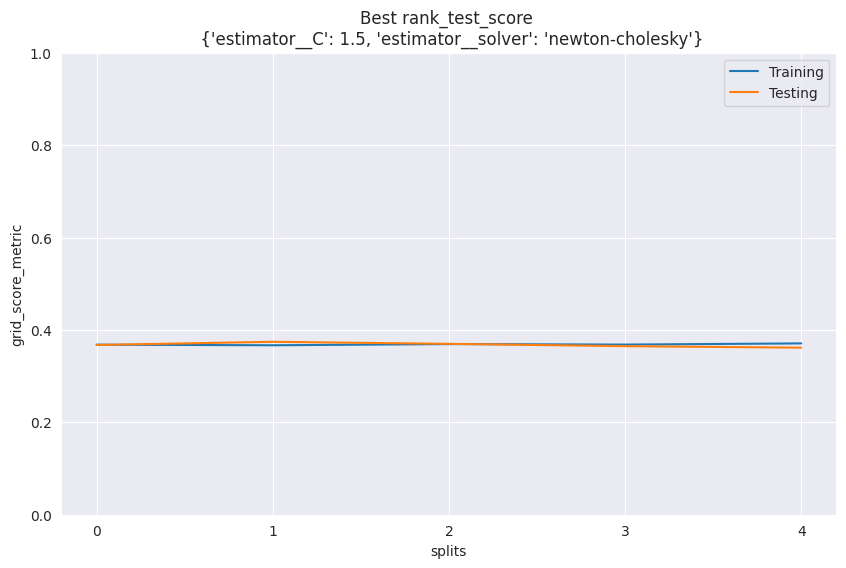

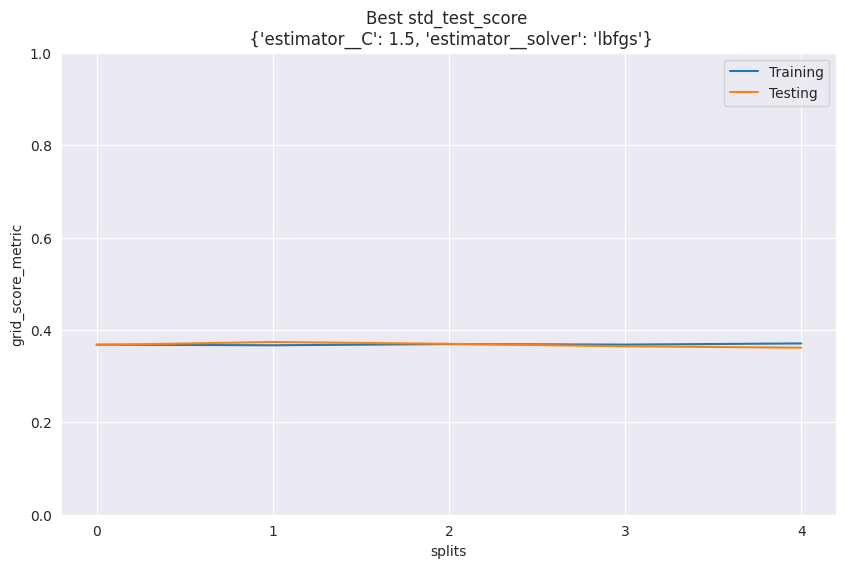

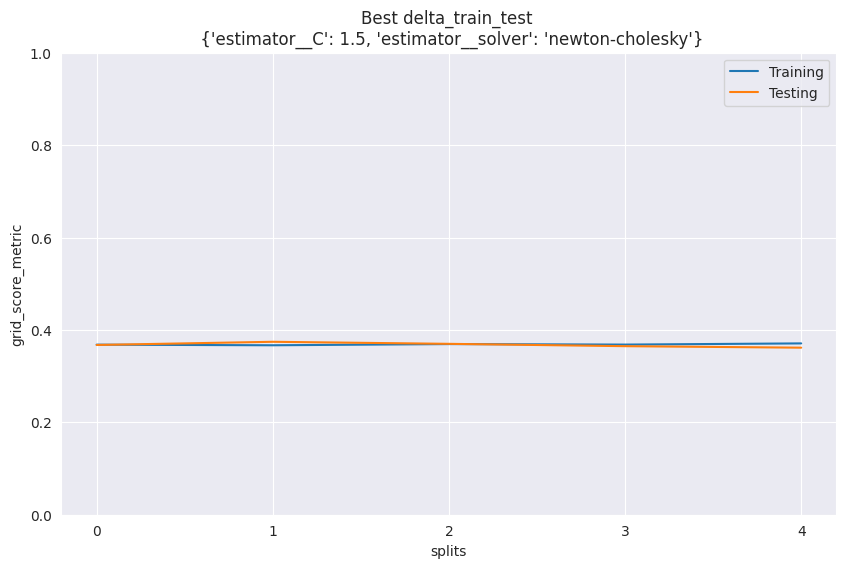

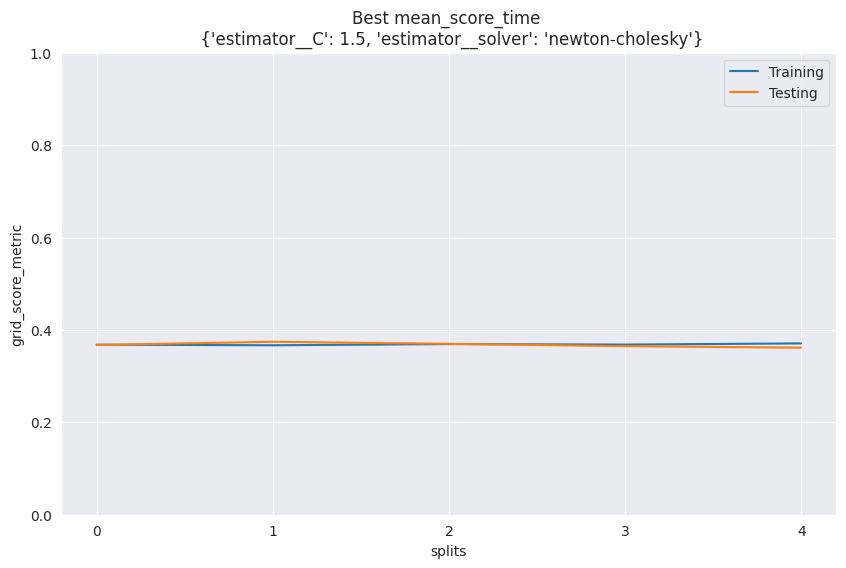

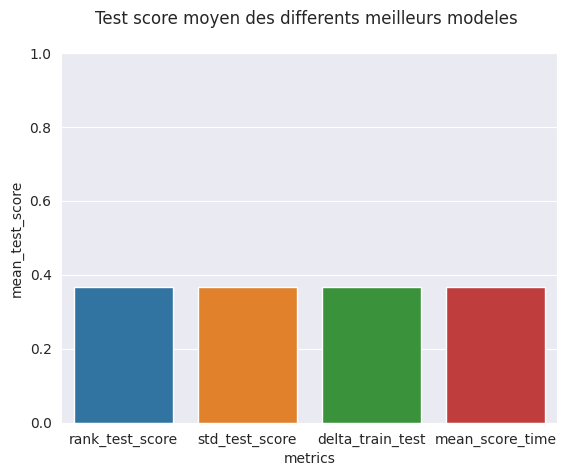

In [6]:
grid_results = gs810.grid_resultification(grid=model)
df_to_plot, df_models = gs810.get_split_scores_for_model(res_grid=grid_results, nb_cv=5)
list_img, path_to_models_csv =gs810.plot_split_scores(df_to_plot, df_models, save=True, path=TMP_FOLDER)

In [7]:
grid_results[['params','mean_score_time', 'mean_test_score']]

,params,mean_score_time,mean_test_score
0,"{'estimator__C': 0.5, 'estimator__solver': 'lb...",0.118724,0.367457
1,"{'estimator__C': 0.5, 'estimator__solver': 'ne...",0.104975,0.367543
2,"{'estimator__C': 1, 'estimator__solver': 'lbfgs'}",0.144796,0.367444
3,"{'estimator__C': 1, 'estimator__solver': 'newt...",0.089858,0.367596
4,"{'estimator__C': 1.5, 'estimator__solver': 'lb...",0.132182,0.367444
5,"{'estimator__C': 1.5, 'estimator__solver': 'ne...",0.057976,0.367599


Le modele ayant le mean_score_time le plus faible est aussi un de ceux qui obtient le meilleur mean_test_score.

Dans notre cas, la meilleure option semble donc etre : {'estimator__C': 1.5, 'estimator__solver': 'newton-cholesky'}

In [8]:
ml810.save_grid_results(list_of_image=list_img,
                        grid_estimator=NOM_MODELE_BASE,
                        ini_params="class_weight='balanced', penalty='l2', max_iter=100",
                        path_to_csv=path_to_models_csv)

# TRAIN/TEST BEST MODEL

In [9]:
estimator = LogisticRegression(class_weight='balanced', penalty='l2', max_iter=100,
                               C=1.5, solver='newton-cholesky')

model = Pipeline([
    ("imputer", imputer),
    ("scaler", scaler),
    ("over", over),
    ("under", under),
    ("estimator", estimator)
])

model.fit(X_train, y_train)

Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('scaler', StandardScaler()),
                ('over', SMOTE(random_state=42, sampling_strategy=0.1)),
                ('under',
                 RandomUnderSampler(random_state=42, sampling_strategy=0.5)),
                ('estimator',
                 LogisticRegression(C=1.5, class_weight='balanced',
                                    solver='newton-cholesky'))])

/home/maximorose/anaconda3/envs/oc_ds_p7/lib/python3.10/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


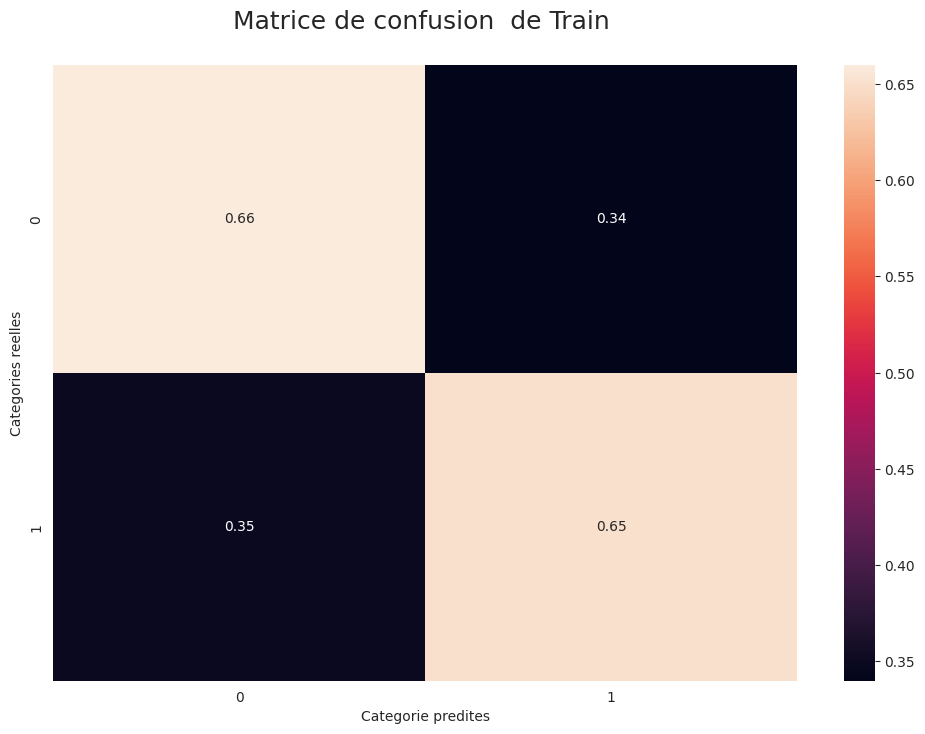

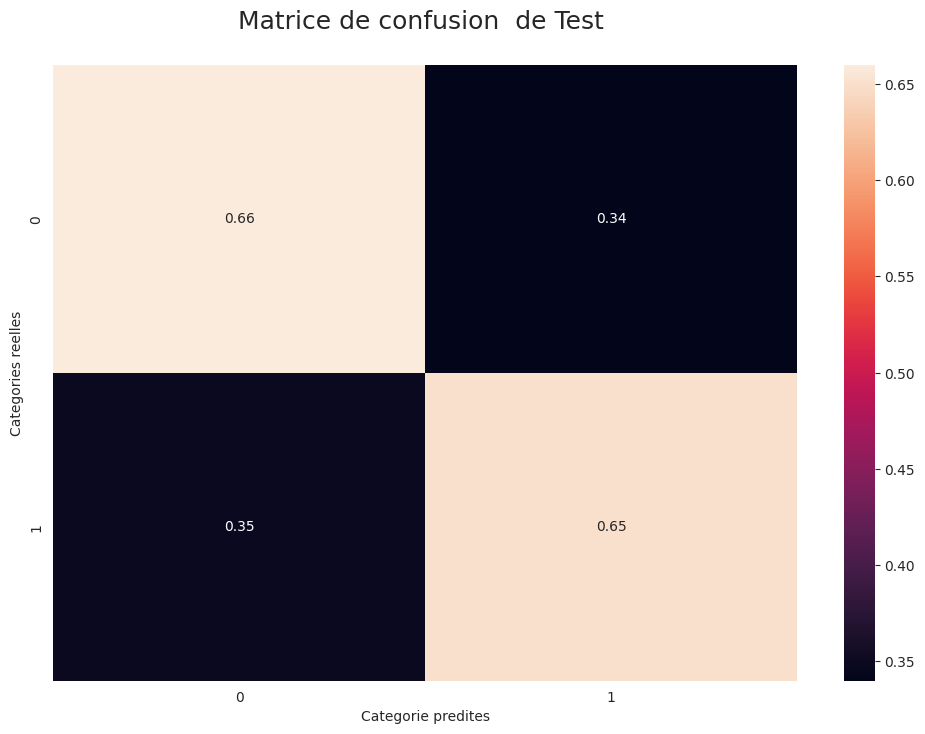

In [10]:
ml810.classification_binaire_save_results(xglob=X, model=model,
                                          xtrain=X_train, ytrain=y_train,
                                          xtest=X_test, ytest=y_test,
                                          nom_model=NOM_MODELE_BASE,
                                          estimator=NOM_MODELE_BASE,
                                          tmp_folder=TMP_FOLDER)